This script fits the optimized base RF model and then perform evaluation and bias analyses based on it.

In [12]:
import numpy as np
import pandas as pd
from scipy import stats
import pickle
from collections import Counter
from sklearn.metrics import precision_recall_curve, roc_auc_score, confusion_matrix, balanced_accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from scipy.stats.mstats import gmean
import math
import datetime as dt
import matplotlib
font = {'size': 24}
matplotlib.rc('font', **font)
import matplotlib.pyplot as plt
import seaborn as sns
import re


df_new = pd.read_stata("df_new.dta")
predictors = pickle.load(open("predictors_rf2.p", "rb"))

In [13]:
def calc_cw(y):
    # Calculate the weight of each letter grade to be used in the modeling fitting procedure: the weight is inversely proportional to the square root of the frequency of the letter grade in the training sample
    cw = Counter(y)
    class_weight = {k:np.sqrt(cw.most_common()[0][-1]/v, dtype=np.float32) for k,v in cw.items()}
    return class_weight # The output is a dictionary mapping letter grade to the corresponding weight

In [14]:
train_df = df_new[df_new.valid == 0]
test_df = df_new[df_new.valid == 1]

optimal_d = 16
optimal_n = 120
optimal_nf = 12
rf = RandomForestClassifier(n_estimators=optimal_n, criterion="entropy",
                            max_depth=optimal_d,
                            random_state=0, n_jobs=-1, max_features=optimal_nf,
                            class_weight = calc_cw(train_df.grad_6years))
rf.fit(train_df.loc[:,predictors], train_df.grad_6years)

RandomForestClassifier(bootstrap=True,
            class_weight={0.0: 1.0, 1.0: 1.3931639}, criterion='entropy',
            max_depth=16, max_features=12, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=120, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [15]:
# Coefficients and predicted scores
y_test_pred_rf = rf.predict_proba(test_df.loc[:,predictors])[:,1]
y_train_pred_rf = rf.predict_proba(train_df.loc[:,predictors])[:,1]
print("Random Forest:")
print("Validation AUC = {}".format(round(roc_auc_score(test_df.grad_6years, y_test_pred_rf),4)))
print("Training AUC = {}".format(round(roc_auc_score(train_df.grad_6years, y_train_pred_rf),4)))

Random Forest:
Validation AUC = 0.8993
Training AUC = 0.9252


In [16]:
roc_auc_score(train_df.grad_6years[np.array(train_df.white == 1)], y_train_pred_rf[np.array(train_df.white == 1)])

0.9258862182969513

In [17]:
roc_auc_score(train_df.grad_6years[np.array(train_df.afam == 1)], y_train_pred_rf[np.array(train_df.afam == 1)])

0.9128502307713119

In [18]:
def efron_rsquare(y, y_pred):
    n = float(len(y))
    t1 = np.sum(np.power(y - y_pred, 2.0))
    t2 = np.sum(np.power((y - (np.sum(y) / n)), 2.0))
    return 1.0 - (t1 / t2)

In [19]:
efron_rsquare(train_df.grad_6years[np.array(train_df.white == 1)], y_train_pred_rf[np.array(train_df.white == 1)])

0.5248441258134005

In [20]:
efron_rsquare(train_df.grad_6years[np.array(train_df.afam == 1)], y_train_pred_rf[np.array(train_df.afam == 1)])

0.4730463703371025

In [8]:
sr = np.mean(train_df.grad_6years)
n = int(train_df.shape[0] - train_df.shape[0] * sr)
best_threshold = sorted(y_train_pred_rf)[n-1]
best_threshold

0.5103012503446723

In [9]:
import matplotlib
font = {'size': 24}
matplotlib.rc('font', **font)
import matplotlib.pyplot as plt

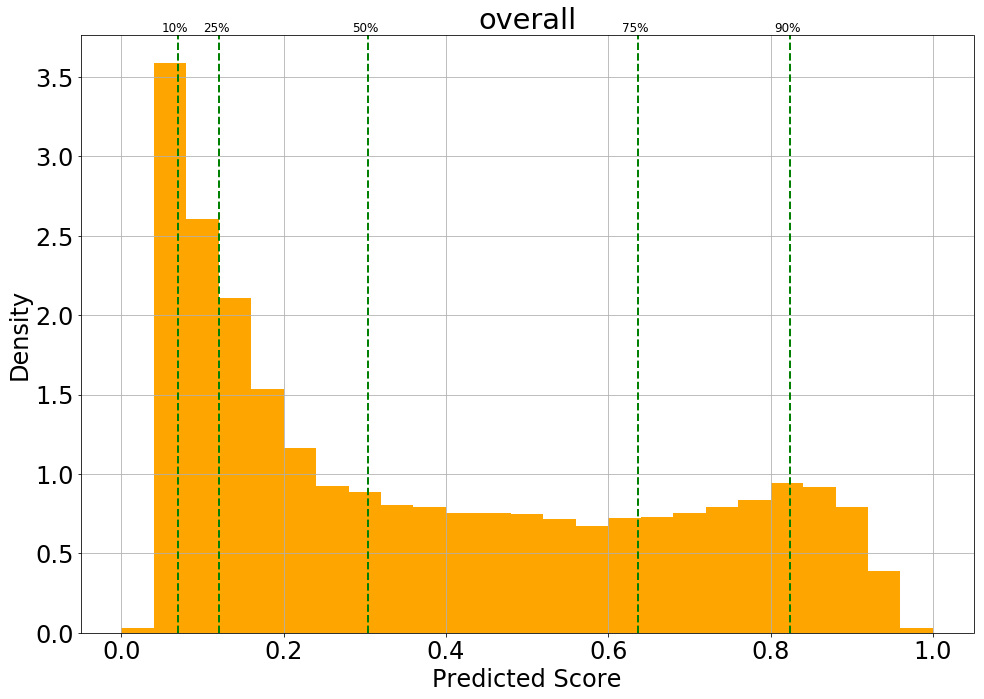

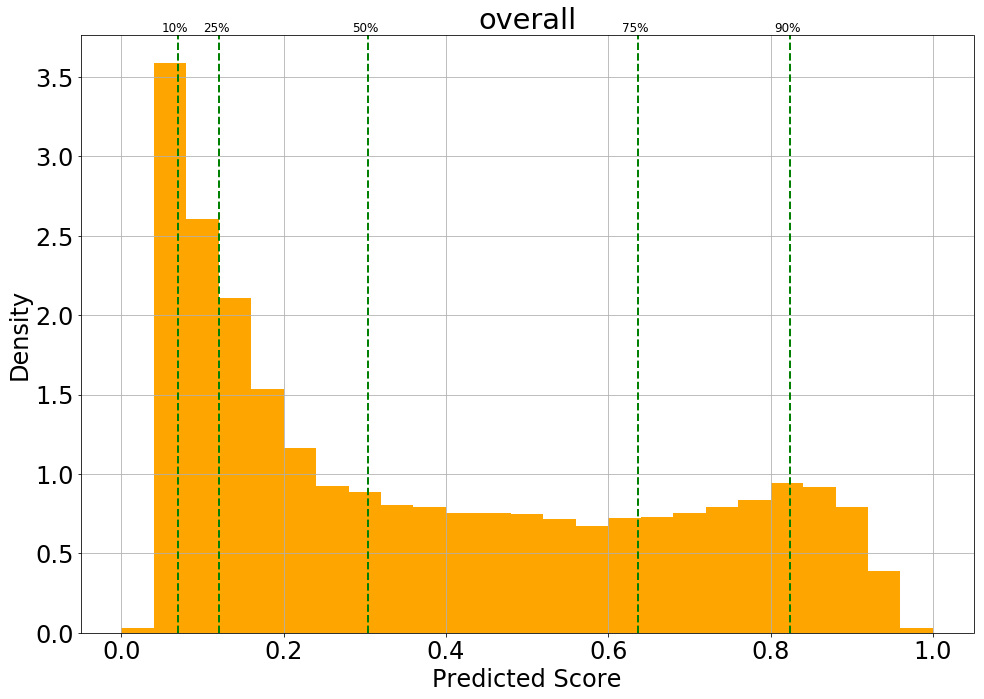

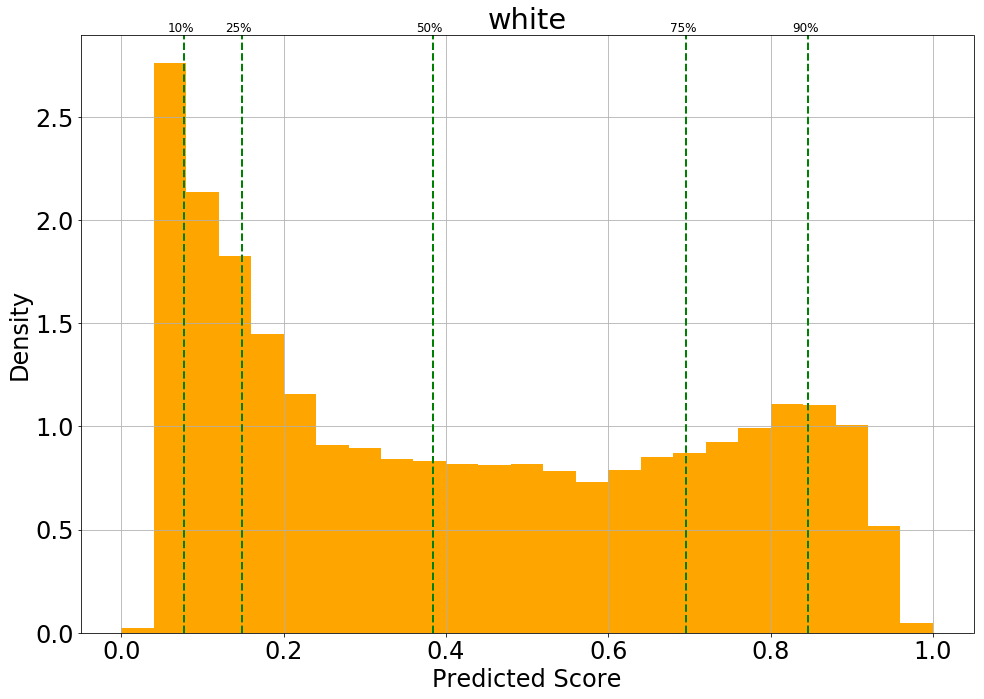

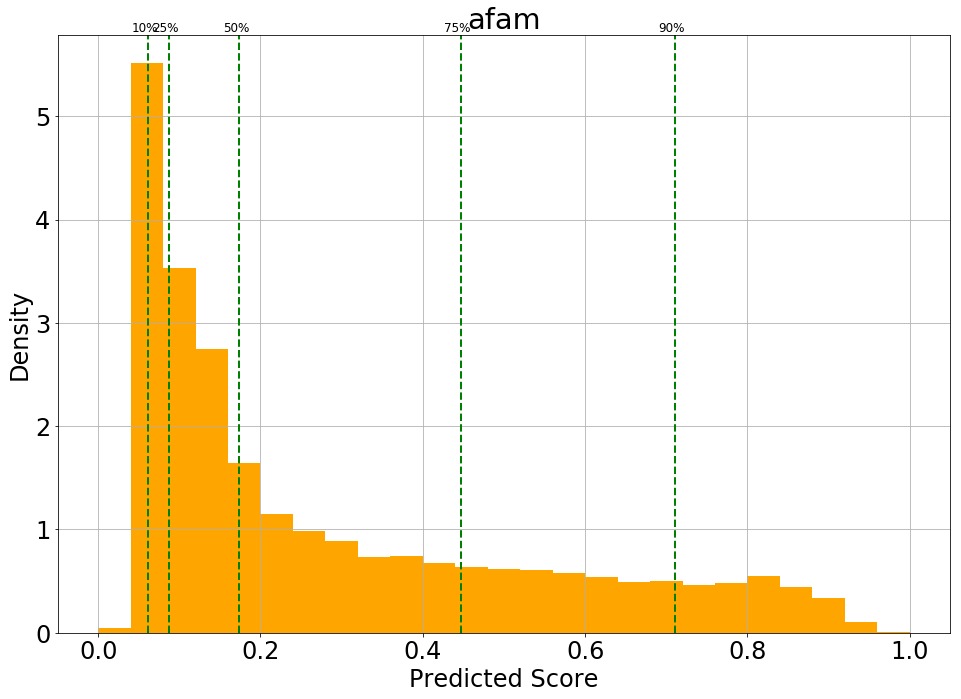

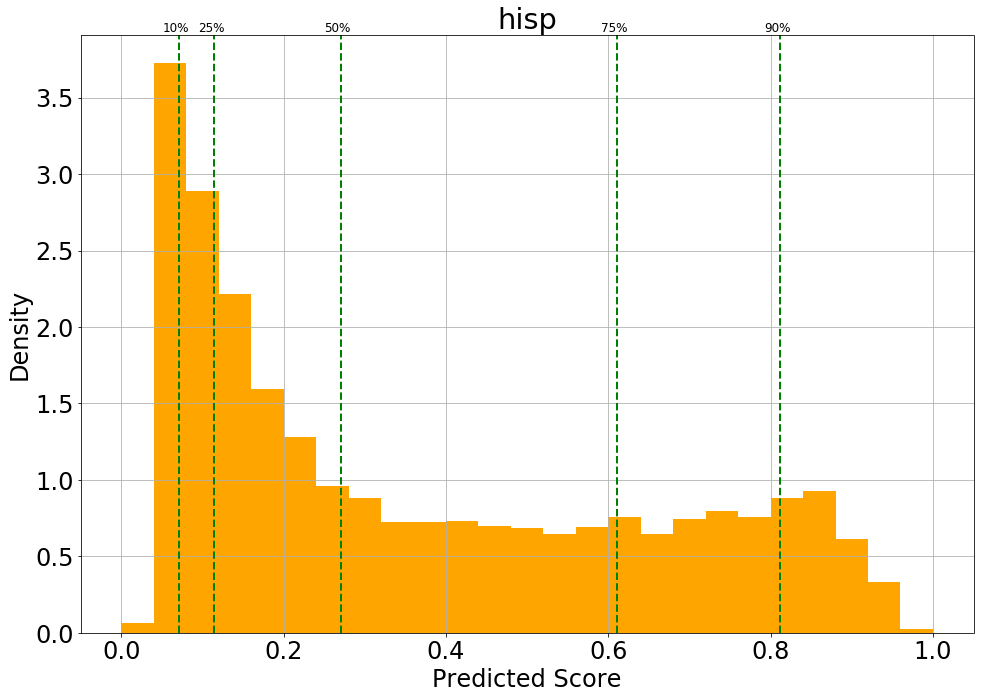

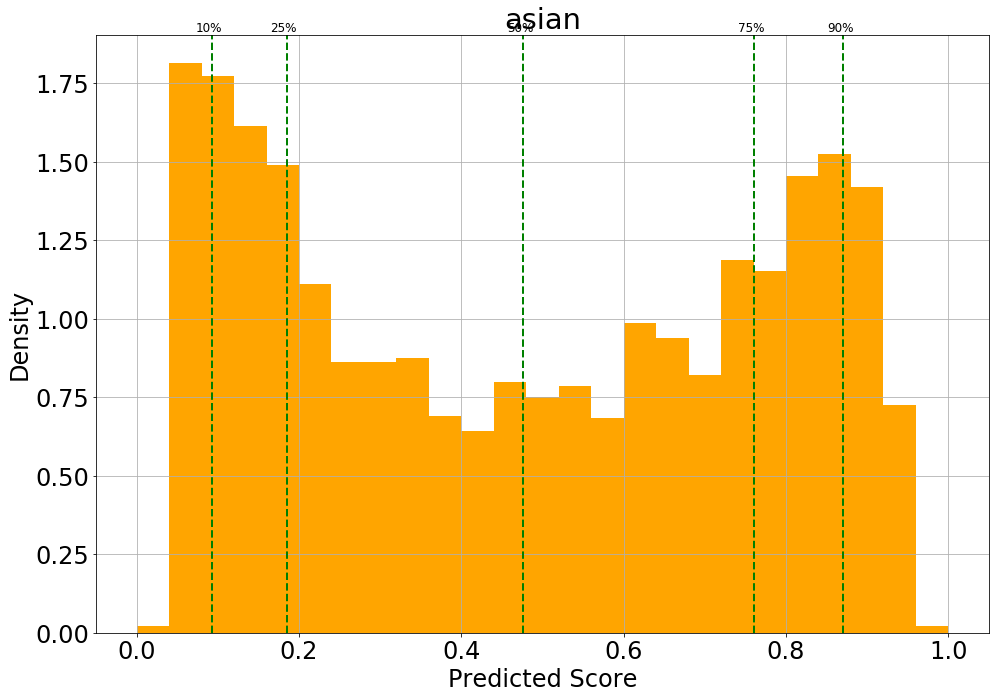

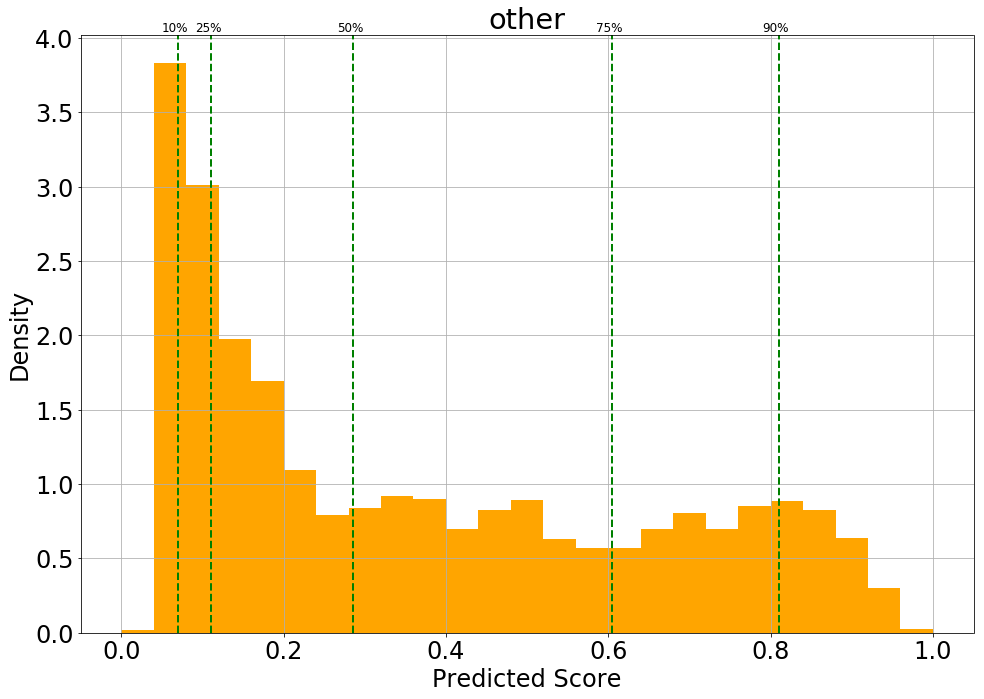

In [11]:
success_rate_1 = []
for r in ['overall', 'white', 'afam', 'hisp', 'asian', 'other']:
    if r == 'overall':
        y_arr = np.array(y_test_pred_rf)
        y_actual = np.array(test_df.grad_6years)
    else:
        y_arr = np.array(y_test_pred_rf)[np.where(np.array(test_df[r]) == 1)[0]]
        y_actual = np.array(test_df.grad_6years)[np.where(np.array(test_df[r]) == 1)[0]]
    success_rate_1.append((r, len(y_arr), np.mean(y_actual), np.mean(y_arr > best_threshold)))
    fig = plt.figure(figsize=(16,11)) 
    ax = fig.add_subplot(1, 1, 1)
    pd.DataFrame({r:y_arr}).hist(r, bins = np.linspace(0,1,26), density=True, color='orange', figsize=(16,11), ax=ax)
    for p,q in zip(np.percentile(y_arr, q = [10,25,50,75,90]), [10,25,50,75,90]):
        ax.axvline(x=p, color='g', linestyle='dashed', linewidth=2)
        ax.text(p-0.02,ax.get_ylim()[1]*1.005,"{}%".format(q),fontsize=12)
    ax.set_xlabel("Predicted Score")
    ax.set_ylabel("Density")
    plt.savefig(r +"_1.png")
    plt.show()